<h2>PerQoDA</h2>
<h3>Dataset Quality Assessment with Permutation Testing</h3>


Load required libraries. You may need to install some packages. Please, see the README for instructions on the installation of weles. The other packages may be installed with pip.

In [2]:
import weles as ws
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

Prepare dataset (X1 - data, y1 - labels). Please, substitute '&lt;path_to_repo&gt;' with the path where you installed the repository.

In [64]:
df = pd.read_csv('<path_to_repo>\jupyter\Examples\inSDN_BFA_2200.csv')
X1 = df.drop(["Label"], axis=1).to_numpy()
y1 = df["Label"].to_numpy()

datasets = {
    "all": (X1, y1)
}

Select classifiers and metric. You may need to install some packages with pip.

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import sensitivity_score

clfs = {
        "KNN": KNeighborsClassifier(),
        "SVM": SVC(),
        "DT": DecisionTreeClassifier(),
        "RF": RandomForestClassifier(),
        "AB": AdaBoostClassifier(),
        "XGB": XGBClassifier(use_label_encoder=False),
        "MLP": MLPClassifier()
}

metrics = {
    "recall": sensitivity_score
}

Run the Weles and save true results

In [ ]:
# cross-validation policy: protocol2=(shuffle, folds, random_state)
ev = ws.evaluation.Evaluator(datasets=datasets, protocol2=(True, 2, None)).process(clfs=clfs, verbose=1)

scores = ev.score(metrics=metrics)

Run the PerQoDA

In [ ]:
nperm = 100 # number of permutations 
perc = [50, 25, 10, 5, 1, 0.1] # percentage of labels
a=np.shape(ev.scores.mean(axis=2)[:, :, 0]) # true results

perm = np.zeros((nperm,len(perc),a[1]))
corr = np.zeros((nperm,len(perc)))

for i in range(nperm):
    for j in range(len(perc)):

        print(i,j)
           
        while True:
            ind1=np.where(y1 == 0)
            ind2=np.where(y1 == 1)
            
            nperc1 = round(perc[j]*len(ind1[0])/100)
            nperc2 = round(perc[j]*len(ind2[0])/100)
        
            indP = np.random.permutation(np.concatenate((ind1[0][:nperc1], ind2[0][:nperc2])))
            ind = np.sort(indP);

            y1P = np.copy(y1);

            y1P[ind] = y1[indP];
            
            comparison = y1 == y1P
            
            if not comparison.all():
                break

        datasetsP = {
          "all": (X1, y1P)
        }

        evP = ws.evaluation.Evaluator(datasets=datasetsP,protocol2=(True, 2, None)).process(clfs=clfs, verbose=0)

        scores = evP.score(metrics=metrics)

        perm[i,j,:] = evP.scores.mean(axis=2)[:, :, 0]
        
        kk = np.corrcoef(y1P,y1)
        corr[i,j] = kk[0,1]

Visualize ML results and print the p-value table

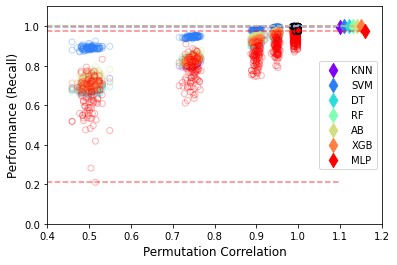

,50%,25%,10%,5%,1%,0.1%
KNN,0.009901,0.009901,0.009901,0.009901,0.009901,0.574257
SVM,0.009901,0.009901,0.009901,0.009901,0.495050,1.000000
DT,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
RF,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
AB,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
XGB,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
MLP,0.009901,0.009901,0.009901,0.009901,0.019802,0.099010


In [83]:
pvalues = np.zeros((a[1],len(perc)))
colors = cm.rainbow(np.linspace(0, 1, a[1]))

# plot true values as diamonds
for i, c in zip(range(a[1]),colors):
    plt.scatter(1.1+i*0.01, ev.scores.mean(axis=2)[:, i, 0], s=100, color=c, marker='d')
    
plt.legend(("KNN","SVM","DT","RF","AB","XGB","MLP"))

# plot lines for true values
for i, c in zip(range(a[1]),colors):
    plt.plot([0, 1.1+i*0.01], [ev.scores.mean(axis=2)[:, i, 0], ev.scores.mean(axis=2)[:, i, 0]], c=c, linestyle='dashed', alpha=0.5)

# plot permutations
colors = cm.rainbow(np.linspace(0, 1, a[1]))
for j in range(len(perc)):
    for i, c in zip(range(a[1]),colors):
        ind = np.where(perm[:,j,i]<ev.scores.mean(axis=2)[:, i, 0])
        plt.scatter((corr[ind,j]), perm[ind,j,i], color="none", edgecolor=c, alpha=0.3)
        
for j in range(len(perc)):
    for i, c in zip(range(a[1]),colors):
        ind = np.where(perm[:,j,i]>=ev.scores.mean(axis=2)[:, i, 0])
        plt.scatter((corr[ind,j]), perm[ind,j,i], color=c, edgecolor="black", alpha=1)
        pvalues[i,j] = ((len(ind[0])+1)*1.0)/(nperm+1);

plt.ylabel('Performance (Recall)', size=12)
plt.xlabel('Permutation Correlation', size=12)       

plt.plot([0, 1.1], [perm.min(), perm.min()], color='red', linestyle='dashed', alpha=0.5)

plt.axis([0.4, 1.2, 0, 1.1])

plt.show()

pv = pd.DataFrame(data=pvalues, index=["KNN","SVM","DT","RF","AB","XGB","MLP"], columns=["50%", "25%", "10%", "5%", "1%", "0.1%"])

def significant(v):
    return "font-weight: bold; color: red" if v > 0.01 else None

pv.style.applymap(significant)

Calculate the slope

KNN = 0.619765352191651
SVM = 0.22422105764523895
DT = 0.6261470137565713
RF = 0.609655264761474
AB = 0.5433090506153689
XGB = 0.6030317190629487
MLP = 0.6041859674254526
Slope: 0.6261470137565713 - DT


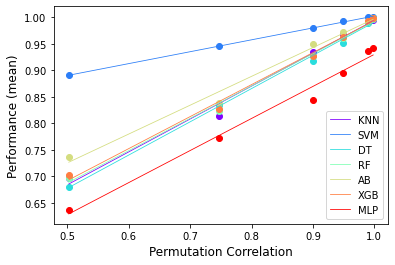

In [84]:
names = ["KNN","SVM","DT","RF","AB","XGB","MLP"]
cor = []
per = []
slopes = []

for i, c in zip(range(a[1]),colors):
    for j in range(len(perc)):
        plt.scatter(np.mean(corr[:,j]), np.mean(perm[:,j,i]), color=c, alpha=1)
    
    cor = np.mean(corr[:,:], axis=0)
    per = np.mean(perm[:,:,i], axis=0)
    
    slope, intercept = np.polyfit(cor, per, 1)
    plt.plot(cor, slope*cor + intercept, color=c, linewidth=0.8)
    print(names[i], '=', slope)
    slopes = np.append(slopes, slope)

plt.legend(names)
plt.ylabel('Performance (mean)', size=12)
plt.xlabel('Permutation Correlation', size=12) 

maxind = np.argmax(slopes)

print('Slope:', np.max(slopes), '-', names[maxind])